In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = yf.download('TGMA3.SA', period='max', auto_adjust=True)

[*********************100%%**********************]  1 of 1 completed


In [3]:
import talib 

data['u_bb'], data['bb_m'], data['l_bb'] = talib.BBANDS(data['Close'], timeperiod = 20)

data['sinal_compra'] = (data['Close'] < data['l_bb']).astype(int)
data['sinal_venda'] = (data['Close'] > data['u_bb']).astype(int)

In [4]:
pd.options.mode.chained_assignment = None 

data["posicao"] = 0
'''
Define se estamos comprados (1) ou não (0).
Se houver um sinal_compra, a posição é definida como 1.
Se houver um sinal_venda, a posição é definida como 0.
Caso contrário, mantemos a posição anterior, assumindo que estamos comprados até um sinal de venda ocorrer.
'''
for i in range(1, len(data)):
    if data['sinal_compra'].iloc[i] == 1:
        data["posicao"].iloc[i] = 1
    elif data['sinal_venda'].iloc[i] == 1:
        data["posicao"].iloc[i] = 0
    else:
        if (data['posicao'].iloc[i-1] == 1) and (data['sinal_venda'].iloc[i] == 0):
            data["posicao"].iloc[i] = 1    
        else:
            data["posicao"].iloc[i] = 0

# Ajusta a posição para evitar viés, fazendo com que a posição seja definida um dia após o sinal.
data["posicao"] = data["posicao"].shift()
# Conta as transições entre posições (de comprado para vendido, ou vice-versa), identificando cada trade.
data['trades'] = (data['posicao'] != data['posicao'].shift()).cumsum() 
data['trades'] = data['trades'].where(data['posicao'] == 1) 

data['retorno'] = data['Close'].pct_change() 

# remover as linhas do DataFrame data onde o valor na coluna "trades" é NaN
data = data.dropna(subset = "trades")

<Axes: xlabel='Date'>

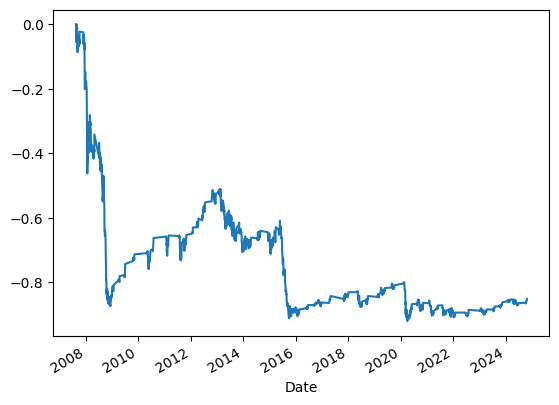

In [5]:
data_retorno_acumulado = (1 + data["retorno"]).cumprod() - 1
data_retorno_acumulado.plot()

In [6]:
data["retorno_cota"] = 1 + data["retorno"]
data["rentabilidade_trades"] = data.groupby("trades")["retorno_cota"].cumprod() - 1

In [7]:
# Filtra apenas o último dia de cada trade para capturar o retorno final.

data = data.sort_index(ascending = False)
data = data.drop_duplicates("trades") 
data = data.sort_index(ascending = True)
data = data.dropna()

data_final = data[["trades", "rentabilidade_trades"]]

In [8]:
data

,Open,High,Low,Close,Volume,u_bb,bb_m,l_bb,sinal_compra,sinal_venda,posicao,trades,retorno,retorno_cota,rentabilidade_trades
Date,,,,,,,,,,,,,,,
2007-10-08,15.483760,16.062441,14.899671,15.332330,57300,15.270647,14.825851,14.381056,0,1,1.0,3.0,0.027174,1.027174,-0.022414
2008-04-30,9.275114,10.005225,9.085826,10.005225,41100,9.635790,9.168573,8.701356,0,1,1.0,5.0,0.089517,1.089517,-0.326293
2009-01-27,2.893403,3.066467,2.893403,3.001568,63500,3.001510,2.742243,2.482976,0,1,1.0,7.0,0.018349,1.018349,-0.707895
2009-04-16,3.236944,3.627609,3.097420,3.493667,101500,3.407443,3.241687,3.075931,0,1,1.0,9.0,0.075601,1.075601,0.138182
2009-07-03,4.375455,4.604273,4.375455,4.548463,179000,4.511562,4.091106,3.670650,0,1,1.0,11.0,0.051613,1.051613,0.172661
2009-11-09,7.018775,7.222218,6.843588,7.222218,166000,7.157312,6.863301,6.569291,0,1,1.0,13.0,0.027332,1.027332,0.115592
2010-06-21,8.263704,8.554680,8.263704,8.554680,47700,8.483577,7.710270,6.936963,0,1,1.0,15.0,0.035211,1.035211,0.042553
2010-08-02,8.612876,9.078437,8.554681,9.078437,111900,8.900577,8.348670,7.796762,0,1,1.0,17.0,0.050505,1.050505,0.129617
2011-02-28,13.349638,13.937022,13.349638,13.937022,161100,13.868329,12.584554,11.300780,0,1,1.0,19.0,0.038462,1.038462,0.023084


In [9]:
# Rentabilidade acumulada ao longo de todos os trades.
rentabilidade_acumulada = ((1 + data_final["rentabilidade_trades"]).cumprod() - 1).iloc[-1]
# Proporção de trades lucrativos e não lucrativos.
trades_certos = (len(data[data["rentabilidade_trades"] > 0]))/len(data["rentabilidade_trades"])
trades_errados = 1 - trades_certos
# Média de rentabilidade dos trades lucrativos e das perdas dos trades negativos.
media_ganhos = data[data["rentabilidade_trades"] > 0]["rentabilidade_trades"].mean()
media_perdas = data[data["rentabilidade_trades"] <= 0]["rentabilidade_trades"].mean()
# Expectativa matemática, calculada como a média ponderada dos ganhos e perdas.
EV = (trades_certos * media_ganhos) - (trades_errados * abs(media_perdas))

print(f'''
Rentabilidade Acumulada: {rentabilidade_acumulada}
Trades Certos: {trades_certos}
EV: {EV * 100}
''')


Rentabilidade Acumulada: -0.8513303780585462
Trades Certos: 0.6382978723404256
EV: -0.9970262543190735



In [10]:
data

,Open,High,Low,Close,Volume,u_bb,bb_m,l_bb,sinal_compra,sinal_venda,posicao,trades,retorno,retorno_cota,rentabilidade_trades
Date,,,,,,,,,,,,,,,
2007-10-08,15.483760,16.062441,14.899671,15.332330,57300,15.270647,14.825851,14.381056,0,1,1.0,3.0,0.027174,1.027174,-0.022414
2008-04-30,9.275114,10.005225,9.085826,10.005225,41100,9.635790,9.168573,8.701356,0,1,1.0,5.0,0.089517,1.089517,-0.326293
2009-01-27,2.893403,3.066467,2.893403,3.001568,63500,3.001510,2.742243,2.482976,0,1,1.0,7.0,0.018349,1.018349,-0.707895
2009-04-16,3.236944,3.627609,3.097420,3.493667,101500,3.407443,3.241687,3.075931,0,1,1.0,9.0,0.075601,1.075601,0.138182
2009-07-03,4.375455,4.604273,4.375455,4.548463,179000,4.511562,4.091106,3.670650,0,1,1.0,11.0,0.051613,1.051613,0.172661
2009-11-09,7.018775,7.222218,6.843588,7.222218,166000,7.157312,6.863301,6.569291,0,1,1.0,13.0,0.027332,1.027332,0.115592
2010-06-21,8.263704,8.554680,8.263704,8.554680,47700,8.483577,7.710270,6.936963,0,1,1.0,15.0,0.035211,1.035211,0.042553
2010-08-02,8.612876,9.078437,8.554681,9.078437,111900,8.900577,8.348670,7.796762,0,1,1.0,17.0,0.050505,1.050505,0.129617
2011-02-28,13.349638,13.937022,13.349638,13.937022,161100,13.868329,12.584554,11.300780,0,1,1.0,19.0,0.038462,1.038462,0.023084


                           Strategy
-------------------------  ----------
Start Period               2007-10-08
End Period                 2024-10-22
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -85.13%
CAGR﹪                     -7.43%

Sharpe                     -0.81
Prob. Sharpe Ratio         35.82%
Smart Sharpe               -0.79
Sortino                    -0.91
Smart Sortino              -0.9
Sortino/√2                 -0.64
Smart Sortino/√2           -0.64
Omega                      0.86

Max Drawdown               -89.74%
Longest DD Days            6020
Volatility (ann.)          312.05%
Calmar                     -0.08
Skew                       -2.09
Kurtosis                   5.12

Expected Daily %           -3.97%
Expected Monthly %         -3.97%
Expected Yearly %          -10.05%
Kelly Criterion            -10.5%
Risk of Ruin               0.0%
Daily Value-at-Risk        -33.33%
Expected Shortfall (cVaR)  -33.33%

Max Conse

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-04-30,2020-05-05,2024-10-22,6020,-89.736797,-89.16331


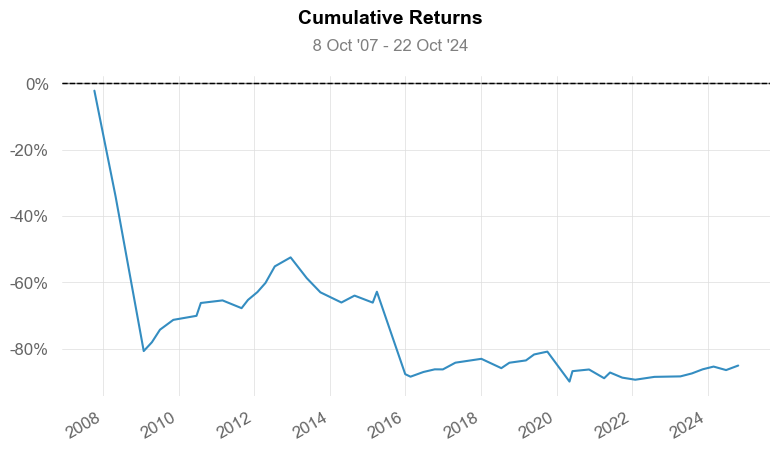

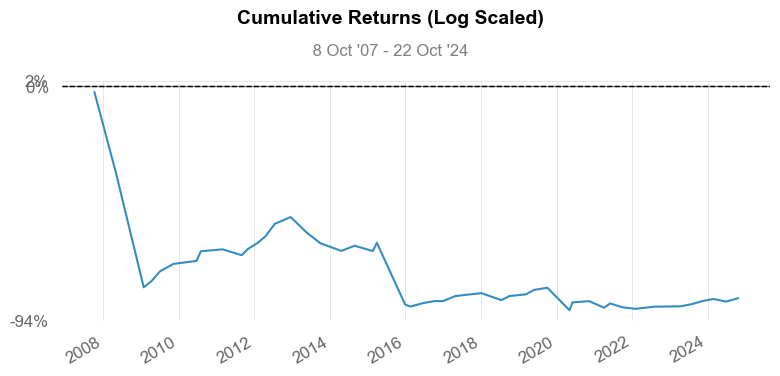

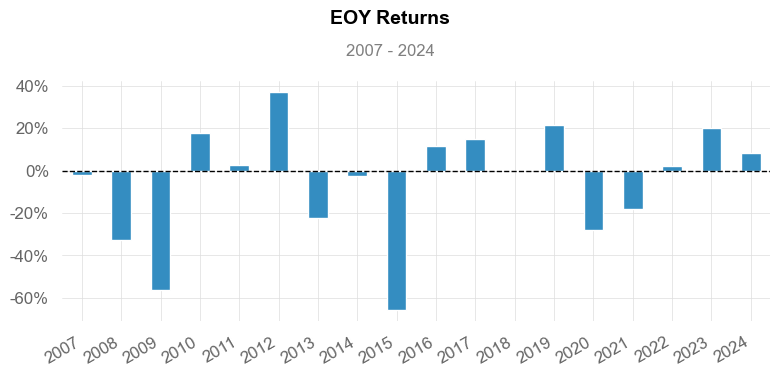

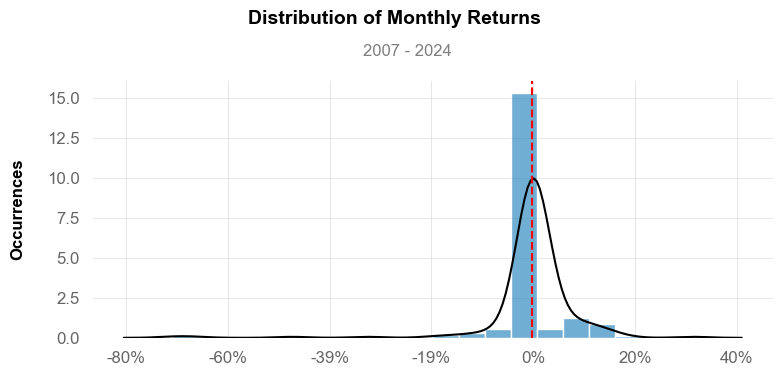

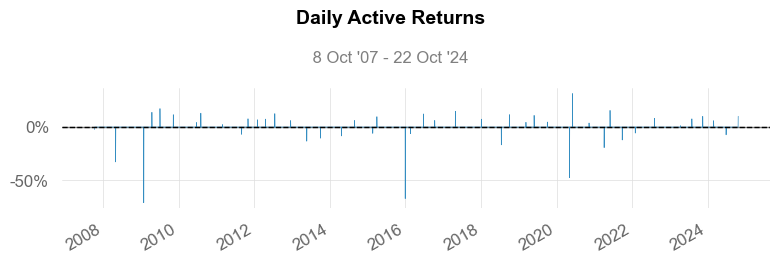

IndexError: index 0 is out of bounds for axis 0 with size 0

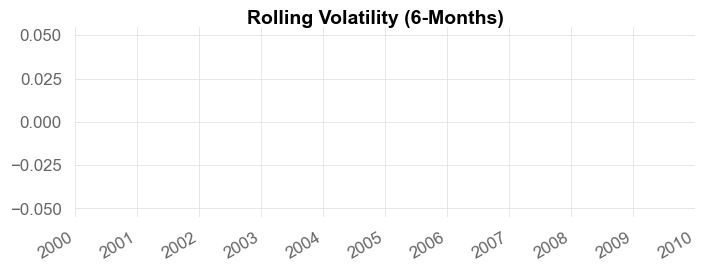

In [11]:
import quantstats as qs
import warnings
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

qs.reports.full(data['rentabilidade_trades'])